In [1]:
from Almanac.Data import get_weather_data
from Almanac.Data import get_frost_dates
from Almanac.Data import binarize
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer
import time

%matplotlib inline

In [2]:
def sarima_forecast(data, config, start=None, end=None):
    order, sorder, trend = config
    model = SARIMAX(
        data,
        order=order,
        seasonal_order=sorder,
        trend=trend,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )

    model_fit = model.fit()

    if (start != None) & (end != None):
        prediction = model_fit.predict(start=start, end=end)
        print("Returning forecast")
        return prediction
    else:
        print("Returning fitted model")
        return model_fit

In [3]:
df = get_weather_data("Chicago, IL", start="2018-01-01", end="2022-12-31")

In [12]:
df

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2018-01-01,-19.1,-21.7,-16.1,0.0,51.0,281.0,16.9,NaN,1041.9,NaN
2018-01-02,-18.5,-23.3,-13.9,0.0,51.0,234.0,18.4,NaN,1035.2,NaN
2018-01-03,-10.0,-13.9,-7.8,0.0,51.0,279.0,20.7,NaN,1021.2,NaN
2018-01-04,-14.0,-16.7,-10.6,0.0,51.0,322.0,19.2,NaN,1027.6,NaN
2018-01-05,-14.8,-17.8,-11.1,0.0,51.0,315.0,16.7,NaN,1032.1,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-12-27,-8.1,-13.3,-3.3,0.0,25.0,210.0,19.8,NaN,1021.5,NaN
2022-12-28,2.7,-3.9,7.2,0.0,0.0,195.0,26.9,NaN,1010.6,NaN
2022-12-29,10.9,6.7,13.9,0.0,0.0,197.0,26.5,NaN,1010.4,NaN


# DO SARIMA forcast on df. Predict 2018-2022 do RFR on those residuals.

In [4]:
config = ((3, 0, 2), (3, 0, 0, 52), "c")

In [5]:
mod = sarima_forecast(df["tmin"].resample("W").min(), config)

Returning fitted model


In [6]:
type(mod)

statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper

In [19]:
start = df["tmin"].resample("W").min().index[0]
end = df["tmin"].resample("W").min().index[-1]

In [22]:
pred = mod.predict(start, end)
act = df["tmin"].resample("W").min()

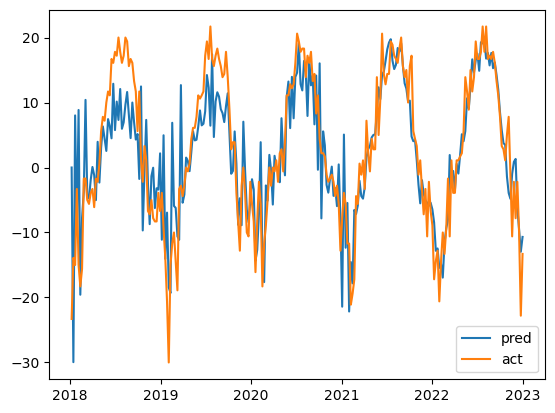

In [624]:
plt.plot(pred)
plt.plot(act)
plt.legend(["pred", "act"])

In [625]:
mod.resid

time
2018-01-07   -23.300000
2018-01-14    16.050339
2018-01-21   -23.015400
2018-01-28     6.797014
2018-02-04   -23.851185
                ...    
2022-12-04    -9.118658
2022-12-11     4.094087
2022-12-18    -0.488687
2022-12-25    -9.834556
2023-01-01    -2.617847
Freq: W-SUN, Length: 261, dtype: float64

In [626]:
rfr = RandomForestRegressor(n_estimators=600)

In [627]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [628]:
df["day_sin"] = sin_transformer(365).fit_transform(df.index.day_of_year)
df["day_cos"] = cos_transformer(365).fit_transform(df.index.day_of_year)

In [629]:
resid = mod.resid.drop("2023-01-01")

In [630]:
rfr.fit(df[["day_sin", "day_cos"]].loc[resid.index], resid)

RandomForestRegressor(n_estimators=9000)

In [631]:
pred_resid = rfr.predict(df[["day_sin", "day_cos"]].loc[resid.index])

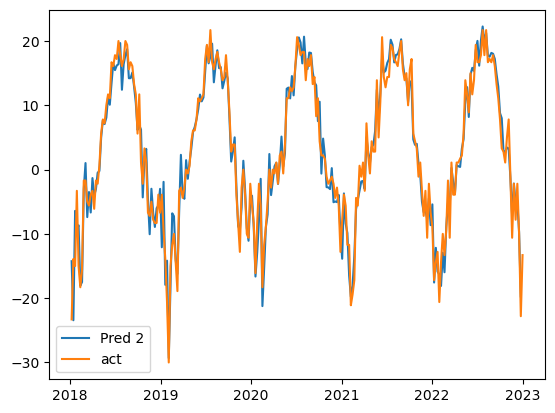

In [632]:
plt.plot(pred.drop("2023-01-01") + pred_resid)
plt.plot(act)
plt.legend(["Pred 2", "act"])

In [633]:
pred_resid

array([-14.24999626,   6.51879533, -14.43514152,   0.91423525,
       -17.51326973,   1.53029281,  -9.72101564,   0.73472073,
        -9.38669925,  -3.15697434,   1.27109937,  -4.77752229,
        -1.40392789,  -2.89169526,   1.97638734,  -4.44521299,
         2.09619921,   1.88384366,   1.34020461,   2.6700737 ,
         5.52959149,   3.84707264,   3.69681872,   8.95432417,
         3.68995981,   9.71976643,   6.04379016,   9.07937727,
         7.60173605,   6.45463272,   9.46680317,   8.15216612,
         7.11317722,   6.16932377,   9.69865447,   5.11178413,
         5.93904069,   6.07787762,   1.02584775,   8.64758053,
        -6.2416921 ,   5.36165681,   2.43510679,  -4.10281206,
        -2.17773982,  -1.33647381,  -1.64411415,  -6.67244866,
        -2.68069141,  -2.80140856,  -2.19292371,  -5.17378672,
        -0.9706557 ,  -6.86653622,  -3.85912096,  -7.22360124,
       -10.86247488,   1.22807839, -13.6830105 ,  -1.3336321 ,
        -7.85099627,  -5.62311348,   4.62141242, -10.38

In [634]:
resid - pred_resid

time
2018-01-07   -9.050004
2018-01-14    9.531544
2018-01-21   -8.580259
2018-01-28    5.882779
2018-02-04   -6.337915
                ...   
2022-11-27   -0.032381
2022-12-04   -2.669308
2022-12-11    2.957280
2022-12-18   -0.322196
2022-12-25   -3.083983
Freq: W-SUN, Length: 260, dtype: float64

In [635]:
# rfr.fit(df[["day_sin","day_cos"]].loc[resid.index],pred.drop("2023-01-01")-pred_resid)

RandomForestRegressor(n_estimators=9000)

In [636]:
# new_pred = rfr.predict(df[["day_sin","day_cos"]].loc[resid.index])

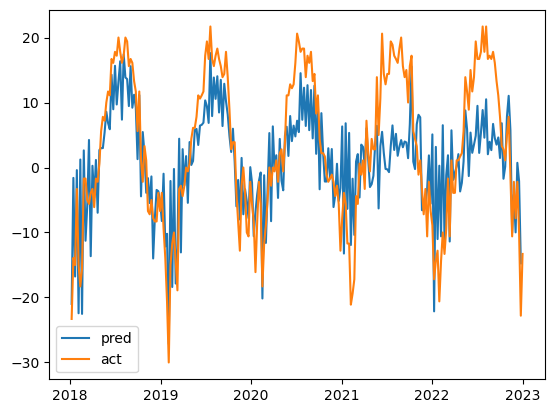

In [637]:
# plt.plot(pred.drop("2023-01-01")+(pred_resid-new_pred))
# plt.plot(act)
# plt.legend(["pred","act"])

In [638]:
# pred.drop("2023-01-01")+(pred_resid-new_pred)

time
2018-01-07   -20.986078
2018-01-14    -1.598942
2018-01-21   -16.773549
2018-01-28    -0.402685
2018-02-04   -22.426804
                ...    
2022-11-27    -4.153185
2022-12-04    -9.982491
2022-12-11     0.722940
2022-12-18    -2.102052
2022-12-25   -14.748465
Freq: W-SUN, Name: predicted_mean, Length: 260, dtype: float64

In [639]:
# act

time
2018-01-07   -23.3
2018-01-14   -13.9
2018-01-21   -15.0
2018-01-28    -3.3
2018-02-04   -15.0
              ... 
2022-12-04    -7.8
2022-12-11    -2.2
2022-12-18   -10.0
2022-12-25   -22.8
2023-01-01   -13.3
Freq: W-SUN, Name: tmin, Length: 261, dtype: float64

In [640]:
# rfr.fit(df[["day_sin","day_cos"]].loc[resid.index],pred.drop("2023-01-01")+(pred_resid-new_pred))

RandomForestRegressor(n_estimators=9000)

In [641]:
# new_pred2 = rfr.predict(df[["day_sin","day_cos"]].loc[resid.index])

In [642]:
first, last = get_frost_dates(df)

In [643]:
first

[Timestamp('2018-10-20 00:00:00'),
 Timestamp('2019-10-31 00:00:00'),
 Timestamp('2020-10-28 00:00:00'),
 Timestamp('2021-11-02 00:00:00'),
 Timestamp('2022-11-13 00:00:00')]

In [644]:
last

[Timestamp('2018-04-18 00:00:00'),
 Timestamp('2019-04-15 00:00:00'),
 Timestamp('2020-05-09 00:00:00'),
 Timestamp('2021-04-22 00:00:00'),
 Timestamp('2022-03-29 00:00:00')]

In [645]:
pred_df = pd.DataFrame(
    {
        "tmin": pred.drop("2023-01-01"),
        "boost": pred.drop("2023-01-01") + pred_resid,
    }
)

In [646]:
pred_df

,tmin,boost
time,,
2018-01-07,0.000000,-14.249996
2018-01-14,-29.950339,-23.431544
2018-01-21,8.015400,-6.419741
2018-01-28,-10.097014,-9.182779
2018-02-04,8.851185,-8.662085
...,...,...
2022-11-27,0.861336,-2.167619
2022-12-04,1.318658,-5.130692
2022-12-11,-6.294087,-5.157280


In [647]:
pred_first, pred_last = get_frost_dates(pred_df)

In [648]:
pred_first

[Timestamp('2018-10-07 00:00:00'),
 Timestamp('2019-10-13 00:00:00'),
 Timestamp('2020-09-27 00:00:00'),
 Timestamp('2021-11-07 00:00:00'),
 Timestamp('2022-10-30 00:00:00')]

In [649]:
pred_last

[Timestamp('2018-04-29 00:00:00'),
 Timestamp('2019-04-28 00:00:00'),
 Timestamp('2020-05-17 00:00:00'),
 Timestamp('2021-04-04 00:00:00'),
 Timestamp('2022-04-17 00:00:00')]

In [650]:
boost_df = pd.DataFrame(
    {
        "pred": pred.drop("2023-01-01"),
        "tmin": pred.drop("2023-01-01") + pred_resid,
    }
)

In [651]:
boost_first, boost_last = get_frost_dates(boost_df)

In [652]:
boost_first

[Timestamp('2018-10-21 00:00:00'),
 Timestamp('2019-11-03 00:00:00'),
 Timestamp('2020-10-11 00:00:00'),
 Timestamp('2021-11-14 00:00:00'),
 Timestamp('2022-11-13 00:00:00')]

In [653]:
boost_last

[Timestamp('2018-04-29 00:00:00'),
 Timestamp('2019-04-21 00:00:00'),
 Timestamp('2020-04-19 00:00:00'),
 Timestamp('2021-04-04 00:00:00'),
 Timestamp('2022-04-03 00:00:00')]

In [654]:
first[0]

Timestamp('2018-10-20 00:00:00')

In [655]:
pred_diff = []

In [656]:
for i, d in enumerate(first):
    pred_diff.append((d - pred_first[i]).days)

In [657]:
boost_diff = []

In [658]:
for i, d in enumerate(first):
    boost_diff.append((d - boost_first[i]).days)

In [659]:
boost_diff

[-1, -3, 17, -12, 0]

In [660]:
pred_diff

[13, 18, 31, -5, 14]

Text(0, 0.5, 'Days')

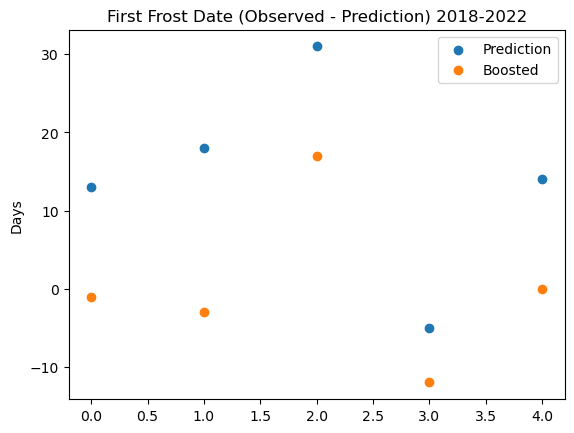

In [661]:
plt.scatter(range(len(pred_diff)), pred_diff)
plt.scatter(range(len(boost_diff)), boost_diff)
plt.legend(["Prediction", "Boosted"])
plt.title("First Frost Date (Observed - Prediction) 2018-2022")
plt.ylabel("Days")

In [662]:
sum(np.abs(boost_diff)) / len(boost_diff)

6.6

In [663]:
sum(np.abs(pred_diff)) / len(pred_diff)

16.2

In [664]:
pred_diff_last = []
boost_diff_last = []

In [665]:
for i, d in enumerate(last):
    pred_diff_last.append((d - pred_last[i]).days)

In [666]:
pred_diff_last

[-11, -13, -8, 18, -19]

In [667]:
for i, d in enumerate(last):
    boost_diff_last.append((d - boost_last[i]).days)

In [668]:
boost_diff_last

[-11, -6, 20, 18, -5]

Text(0, 0.5, 'Days')

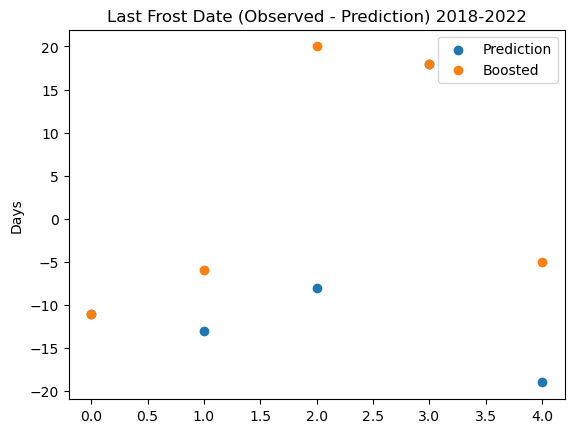

In [669]:
plt.scatter(range(len(pred_diff_last)), pred_diff_last)
plt.scatter(range(len(boost_diff_last)), boost_diff_last)
plt.legend(["Prediction", "Boosted"])
plt.title("Last Frost Date (Observed - Prediction) 2018-2022")
plt.ylabel("Days")

In [670]:
sum(np.abs(boost_diff_last)) / len(boost_diff_last)

12.0

In [671]:
sum(np.abs(pred_diff_last)) / len(pred_diff_last)

13.8

# Forecast Test

In [672]:
df_future = get_weather_data(
    "Chicago, IL", start="2023-01-01", end="2023-12-31"
)

In [673]:
future = mod.predict(start="2023-01-01", end="2023-12-31")

In [674]:
future

2023-01-01   -10.682153
2023-01-08    -6.151388
2023-01-15    -8.171074
2023-01-22    -9.867391
2023-01-29   -11.630997
2023-02-05   -15.208360
2023-02-12   -16.507805
2023-02-19   -11.724744
2023-02-26    -4.679217
2023-03-05    -3.314681
2023-03-12    -2.280974
2023-03-19    -1.997567
2023-03-26    -0.324310
2023-04-02    -1.208800
2023-04-09     4.843656
2023-04-16     1.218141
2023-04-23     1.306043
2023-04-30     3.209462
2023-05-07     2.194625
2023-05-14     6.141438
2023-05-21    12.999637
2023-05-28     8.941456
2023-06-04    12.673349
2023-06-11    15.337605
2023-06-18    13.713051
2023-06-25    15.735626
2023-07-02    17.717539
2023-07-09    17.243539
2023-07-16    18.609030
2023-07-23    19.297485
2023-07-30    17.836799
2023-08-06    16.799490
2023-08-13    16.926773
2023-08-20    17.452552
2023-08-27    18.615169
2023-09-03    15.344328
2023-09-10    14.761022
2023-09-17    12.233621
2023-09-24    11.026996
2023-10-01     9.860009
2023-10-08     8.663511
2023-10-15     4

In [675]:
future_forec = pd.DataFrame({"forecast": future})

In [676]:
future_forec["day_sin"] = sin_transformer(365).fit_transform(
    future_forec.index.day_of_year
)
future_forec["day_cos"] = cos_transformer(365).fit_transform(
    future_forec.index.day_of_year
)

In [696]:
future_forec.head()

,forecast,day_sin,day_cos,resid_pred,tmin,tmin_bin
2023-01-01,-10.682153,0.017213,0.999852,3.245077,-7.437076,1.0
2023-01-08,-6.151388,0.137279,0.990532,-19.302695,-25.454082,1.0
2023-01-15,-8.171074,0.255353,0.966848,1.229606,-6.941467,1.0
2023-01-22,-9.867391,0.369725,0.929141,-12.485309,-22.352700,1.0
2023-01-29,-11.630997,0.478734,0.877960,-0.760566,-12.391563,1.0


In [678]:
resid_pred = rfr.predict(future_forec[["day_sin", "day_cos"]])

In [679]:
future_forec["resid_pred"] = resid_pred

In [695]:
future_forec.head()

,forecast,day_sin,day_cos,resid_pred,tmin,tmin_bin
2023-01-01,-10.682153,0.017213,0.999852,3.245077,-7.437076,1.0
2023-01-08,-6.151388,0.137279,0.990532,-19.302695,-25.454082,1.0
2023-01-15,-8.171074,0.255353,0.966848,1.229606,-6.941467,1.0
2023-01-22,-9.867391,0.369725,0.929141,-12.485309,-22.352700,1.0
2023-01-29,-11.630997,0.478734,0.877960,-0.760566,-12.391563,1.0


In [681]:
future_forec["tmin"] = future_forec["forecast"] + future_forec["resid_pred"]

In [694]:
future_forec.head()

,forecast,day_sin,day_cos,resid_pred,tmin,tmin_bin
2023-01-01,-10.682153,0.017213,0.999852,3.245077,-7.437076,1.0
2023-01-08,-6.151388,0.137279,0.990532,-19.302695,-25.454082,1.0
2023-01-15,-8.171074,0.255353,0.966848,1.229606,-6.941467,1.0
2023-01-22,-9.867391,0.369725,0.929141,-12.485309,-22.352700,1.0
2023-01-29,-11.630997,0.478734,0.877960,-0.760566,-12.391563,1.0


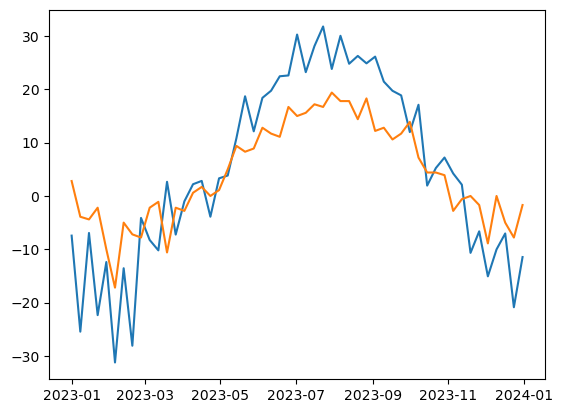

In [683]:
plt.plot(future_forec["tmin"])
plt.plot(df_future["tmin"].resample("W").min())

In [684]:
future_first, future_last = get_frost_dates(df_future)

In [685]:
future_first

[Timestamp('2023-10-30 00:00:00')]

In [686]:
future_first_pred, future_last_pred = get_frost_dates(future_forec)

In [687]:
future_first_pred

[Timestamp('2023-11-19 00:00:00')]

In [688]:
future_last

[Timestamp('2023-04-17 00:00:00')]

In [689]:
future_last_pred

[Timestamp('2023-04-23 00:00:00')]

In [690]:
future_forec2 = pd.DataFrame({"tmin": future})

In [691]:
future_first_unboost, future_last_unboost = get_frost_dates(future_forec2)

In [692]:
print(future_last_unboost, future_last_pred, future_last)

[Timestamp('2023-04-02 00:00:00')] [Timestamp('2023-04-23 00:00:00')] [Timestamp('2023-04-17 00:00:00')]


In [693]:
print(
    f"""2023 Frost Date Predictions:

Fall:
Unboosted SARIMA Fall Frost: {future_first_unboost}
Boosted SARIMA Fall Frost: {future_first_pred}
Observed Fall Frost: {future_first}

Spring:
Unboosted SARIMA Spring Frost: {future_last_unboost}
Boosted SARIMA Spring Frost: {future_last_pred}
Observed Spring Frost: {future_last}
"""
)

2023 Frost Date Predictions:

Fall:
Unboosted SARIMA Fall Frost: [Timestamp('2023-11-19 00:00:00')]
Boosted SARIMA Fall Frost: [Timestamp('2023-11-19 00:00:00')]
Observed Fall Frost: [Timestamp('2023-10-30 00:00:00')]

Spring:
Unboosted SARIMA Spring Frost: [Timestamp('2023-04-02 00:00:00')]
Boosted SARIMA Spring Frost: [Timestamp('2023-04-23 00:00:00')]
Observed Spring Frost: [Timestamp('2023-04-17 00:00:00')]



# Backtesting

In [ ]:
"""
Loop over years with year being the target year to forecast.
get weather data for (year-5)-01-01 to (year-1)-12-31
run sarima_forecast on that data to get fitted model
do sin and cos transforms
train random forest regressor with sin and cos transforms as features and residuals of sarima model as target
sarima forecast the target year
add predicted residual from RFR
"""

In [285]:
years = range(1985, 2024)
config = ((3, 0, 2), (3, 0, 0, 52), "c")
predictions_dict = {}

In [327]:
for year in years:
    print(year)

    for i in range(3):
        try:
            df = get_weather_data(
                "Chicago, IL", f"{year-5}-01-01", f"{year-1}-12-31"
            )
        except Exception:
            print(f"Pause {i}")
            time.sleep(15)
            continue

    model_data = (
        df["tmin"]
        .resample("W")
        .min()[df["tmin"].resample("W").min().index.year < year]
    )

    model = sarima_forecast(model_data, config)

    start = df["tmin"].resample("W").min().index[0]
    end = model_data.index[-1]

    train_prediction = model.predict(start, end)
    rfr = RandomForestRegressor(n_estimators=600)

    df["day_sin"] = sin_transformer(365).fit_transform(df.index.day_of_year)
    df["day_cos"] = cos_transformer(365).fit_transform(df.index.day_of_year)

    resid = model.resid[model.resid.index.year < year]

    rfr.fit(df[["day_sin", "day_cos"]].loc[resid.index], resid)

    pred_resid = rfr.predict(df[["day_sin", "day_cos"]].loc[resid.index])

    test_prediction = model.predict(start=f"{year}-01-01", end=f"{year}-12-31")

    test_pred_df = pd.DataFrame({"forecast": test_prediction})

    test_pred_df["day_sin"] = sin_transformer(365).fit_transform(
        test_pred_df.index.day_of_year
    )
    test_pred_df["day_cos"] = cos_transformer(365).fit_transform(
        test_pred_df.index.day_of_year
    )

    resid_pred = rfr.predict(test_pred_df[["day_sin", "day_cos"]])

    test_pred_df["resid_pred"] = resid_pred

    test_pred_df["boosted forecast"] = (
        test_pred_df["forecast"] + test_pred_df["resid_pred"]
    )

    for i in range(3):
        try:
            observed = get_weather_data(
                "Chicago, IL", f"{year}-01-01", f"{year}-12-31"
            )
        except Exception:
            print(f"Pause2 {i}")
            time.sleep(20)
            continue

    test_pred_df["observed"] = observed["tmin"].resample("W").min()
    predictions_dict[year] = test_pred_df

1985
Pause 1
Returning fitted model
Pause2 1
1986
Pause 0
Pause 2
Returning fitted model
Pause2 1
1987
Pause 0
Pause 2


Returning fitted model
Pause2 1
1988
Pause 0
Pause 2
Returning fitted model
Pause2 1
1989
Pause 0
Pause 2
Returning fitted model
Pause2 1
1990
Pause 0
Pause 2


Returning fitted model
Pause2 1
1991
Pause 0
Pause 2


Returning fitted model
Pause2 1
1992
Pause 0
Pause 2


Returning fitted model
Pause2 1
1993
Pause 0
Pause 2


Returning fitted model
Pause2 1
1994
Pause 0
Pause 2
Returning fitted model
Pause2 1
1995
Pause 0
Pause 2
Returning fitted model
Pause2 1
1996
Pause 0
Pause 2
Returning fitted model
Pause2 1
1997
Pause 0
Pause 2
Returning fitted model
Pause2 1
1998
Pause 0
Pause 2
Returning fitted model
Pause2 1
1999
Pause 0
Pause 2


Returning fitted model
Pause2 1
2000
Pause 0
Pause 2
Returning fitted model
Pause2 1
2001
Pause 0
Pause 2
Returning fitted model
Pause2 1
2002
Pause 0
Pause 2


Returning fitted model
Pause2 1
2003
Pause 0
Pause 2
Returning fitted model
Pause2 1
2004
Pause 0
Pause 2


Returning fitted model
Pause2 1
2005
Pause 0
Pause 2


Returning fitted model
Pause2 1
2006
Pause 0
Pause 2
Returning fitted model
Pause2 1
2007
Pause 0
Pause 2


Returning fitted model
Pause2 1
2008
Pause 0
Pause 2


Returning fitted model
Pause2 1
2009
Pause 0
Pause 2


Returning fitted model
Pause2 1
2010
Pause 0
Pause 2


Returning fitted model
Pause2 1
2011
Pause 0
Pause 2


Returning fitted model
Pause2 1
2012
Pause 0
Pause 2


Returning fitted model
Pause2 1
2013
Pause 0
Pause 2
Returning fitted model
Pause2 1
2014
Pause 0
Pause 2
Returning fitted model
Pause2 1
2015
Pause 0
Pause 2
Returning fitted model
Pause2 1
2016
Pause 0
Pause 2


Returning fitted model
Pause2 1
2017
Pause 0
Pause 2
Returning fitted model
Pause2 1
2018
Pause 0
Pause 2
Returning fitted model
Pause2 1
2019
Pause 0
Pause 2
Returning fitted model
Pause2 1
2020
Pause 0
Pause 2
Returning fitted model
Pause2 1
2021
Pause 0
Pause 2


Returning fitted model
Pause2 1
2022
Pause 0
Pause 2


Returning fitted model
Pause2 1
2023
Pause 0
Pause 2


Returning fitted model
Pause2 1



Loop through predictions_dict set column tmin equal to the unboosted, boosted, and observed columns to use get_frost_dates


In [341]:
obs_dict = {}
fore_dict = {}
boost_dict = {}

### Get backtested frost dates

In [364]:
for year in years:
    pred_df = predictions_dict[year]

    pred_df["tmin"] = pred_df["observed"]

    first_observed, last_observed = get_frost_dates(pred_df)

    obs_dict[year] = [first_observed[0], last_observed[0]]
    pred_df.drop("tmin_bin", axis=1, inplace=True)

    pred_df["tmin"] = pred_df["forecast"]

    first_fore, last_fore = get_frost_dates(pred_df)

    fore_dict[year] = [first_fore[0], last_fore[0]]

    pred_df.drop("tmin_bin", axis=1, inplace=True)

    pred_df["tmin"] = pred_df["boosted forecast"]

    first_boost, last_boost = get_frost_dates(pred_df)

    boost_dict[year] = [first_boost[0], last_boost[0]]

### Get differences

In [373]:
fall = {}
spring = {}

fall_boost = {}
spring_boost = {}

In [412]:
# NOTE 1996 non boosted model predicts no days below zero in fall/winter

for year in years:
    print(year)
    try:
        fall[year] = (obs_dict[year][0] - fore_dict[year][0]).days
    except TypeError:
        fall[year] = 365

    spring[year] = (obs_dict[year][1] - fore_dict[year][1]).days

    fall_boost[year] = (obs_dict[year][0] - boost_dict[year][0]).days
    spring_boost[year] = (obs_dict[year][1] - boost_dict[year][1]).days

1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


Text(0.5, 0, 'Year')

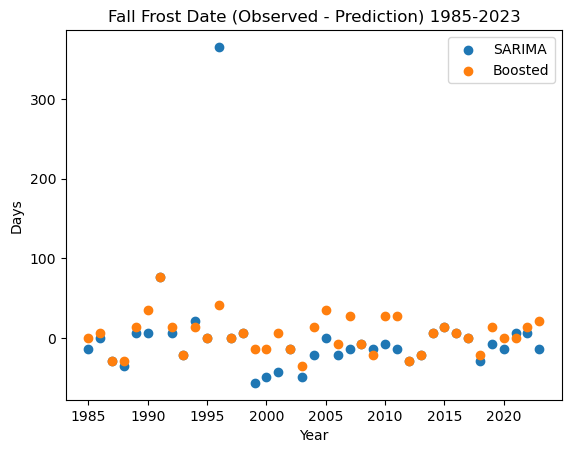

In [402]:
plt.scatter(x=np.arange(1985, 2024), y=fall.values())
plt.scatter(x=np.arange(1985, 2024), y=fall_boost.values())
plt.legend(["SARIMA", "Boosted"])
plt.title("Fall Frost Date (Observed - Prediction) 1985-2023")
plt.ylabel("Days")
plt.xlabel("Year")

Text(0.5, 0, 'Year')

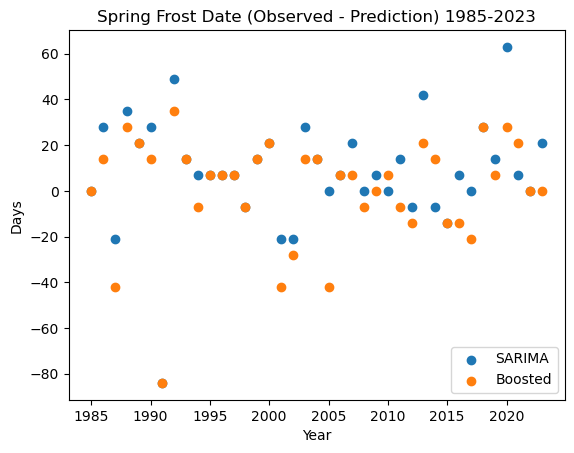

In [418]:
plt.scatter(x=np.arange(1985, 2024), y=spring.values())
plt.scatter(x=np.arange(1985, 2024), y=spring_boost.values())
plt.legend(["SARIMA", "Boosted"])
plt.title("Spring Frost Date (Observed - Prediction) 1985-2023")
plt.ylabel("Days")
plt.xlabel("Year")

In [413]:
np.abs(list(fall.values())).mean()

26.94871794871795

In [414]:
np.abs(list(fall_boost.values())).mean()

17.58974358974359

In [415]:
np.abs(list(spring.values())).mean()

17.76923076923077

In [417]:
np.abs(list(spring_boost.values())).mean()

17.41025641025641

In [394]:
fall

{1985: -14,
 1986: 0,
 1987: -28,
 1988: -35,
 1989: 7,
 1990: 7,
 1991: 77,
 1992: 7,
 1993: -21,
 1994: 21,
 1995: 0,
 1996: 365,
 1997: 0,
 1998: 7,
 1999: -56,
 2000: -49,
 2001: -42,
 2002: -14,
 2003: -49,
 2004: -21,
 2005: 0,
 2006: -21,
 2007: -14,
 2008: -7,
 2009: -14,
 2010: -7,
 2011: -14,
 2012: -28,
 2013: -21,
 2014: 7,
 2015: 14,
 2016: 7,
 2017: 0,
 2018: -28,
 2019: -7,
 2020: -14,
 2021: 7,
 2022: 7,
 2023: -14}

In [432]:
t = [x for x in fall.keys() if x != 1996]
tt = []
for i in t:
    tt.append(fall_boost[i])

In [433]:
np.mean(np.abs(tt))

16.94736842105263

[0,
 7,
 -28,
 -28,
 14,
 35,
 77,
 14,
 -21,
 14,
 0,
 0,
 7,
 -14,
 -14,
 7,
 -14,
 -35,
 14,
 35,
 -7,
 28,
 -7,
 -21,
 28,
 28,
 -28,
 -21,
 7,
 14,
 7,
 0,
 -21,
 14,
 0,
 0,
 14,
 21]

RandomForestRegressor(n_estimators=610)